In [2]:
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt
# Sample Data

patients = pd.read_csv("~/Database/patient_metadata.csv")
data_metadata = pd.read_csv("~/Database/data_metadata.csv")
redcap = pd.read_csv("~/Database/Redcap_metadata.csv", low_memory=False)
sample_metadata = pd.read_csv("~/Database/sample_metadata.csv")
patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
patient_info = patient_info.dropna(axis=1, how="all")

diagnosis_treatment = redcap[
    (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
    (redcap["Repeat Instrument"] == "Treatment at Study Site")
]

diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")

def process_redcap_data(redcap):
    """Clean and split the REDCap data."""
    patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
    patient_info = patient_info.dropna(axis=1, how="all")

    diagnosis_treatment = redcap[
        (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
        (redcap["Repeat Instrument"] == "Treatment at Study Site")
    ]
    diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")
    merged = pd.merge(patient_info, diagnosis_treatment, on="REDCap Record ID")

    final_df = pd.concat([patient_info, merged], ignore_index=True)
    final_df = final_df.rename(columns={'REDCap Record ID': 'REDCAP ID'})
    return final_df

final_df = process_redcap_data(redcap)

print(final_df.columns)

patients = pd.read_csv("~/Database/patient_metadata.csv")
data_metadata = pd.read_csv("~/Database/data_metadata.csv")
redcap = pd.read_csv("~/Database/Redcap_metadata.csv", low_memory=False)
sample_metadata = pd.read_csv("~/Database/sample_metadata.csv")
patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
patient_info = patient_info.dropna(axis=1, how="all")
diagnosis_treatment = redcap[
    (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
    (redcap["Repeat Instrument"] == "Treatment at Study Site")
]
diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")
merged = pd.merge(patient_info, diagnosis_treatment, on="REDCap Record ID")
final_df = pd.concat([patient_info, merged], ignore_index=True)
final_df = final_df.rename(columns={'REDCap Record ID': 'REDCAP ID'})
merged_df = pd.merge(patients, final_df, on="REDCAP ID", how="outer")
combined_df = pd.merge(merged_df, data_metadata, on=["Patient ID"],how="outer")
combined_df = pd.merge(combined_df, sample_metadata, on=["Patient ID","Specimen ID","Sample ID"],how="outer")
combined_df = combined_df.dropna(subset=['Patient ID'])
print(combined_df)

Index(['REDCAP ID', 'Subject ID', 'Updated By', 'Date of Last Update',
       'Gender', 'Race', 'Religion', 'Date of Last Follow Up',
       'Date of Consent for Sarcoma/Melanoma/GIST Study', 'Waiver of Consent',
       ...
       'Site of Relapse/Progression (choice=Local site)',
       'Site of Relapse/Progression (choice=Liver)',
       'Site of Relapse/Progression (choice=Lungs)',
       'Site of Relapse/Progression (choice=Bones)',
       'Site of Relapse/Progression (choice=Brains)',
       'Site of Relapse/Progression (choice=Nodes)',
       'Site of Relapse/Progression (choice=Peritoneum)',
       'Site of Relapse/Progression (choice=Others)',
       'If Others, please specify.27', 'ECOG at Time of Relapse/Progression'],
      dtype='object', length=280)
      REDCAP ID Patient ID Center Data owner  Sex Race_x  Ethnicity Country   \
0           NaN     94T778    NaN        NaN  NaN    NaN        NaN      NaN   
1           NaN        Dx5    NaN        NaN  NaN    NaN        NaN

In [254]:
import altair as alt
import pandas as pd
import altair as alt
import pandas as pd

def interactive_plot(combined_df): 
    combined_df["Patient_Sample_Specimen"] = (
        combined_df["Patient ID"].astype(str) + "_" +
        combined_df["Sample ID"].astype(str) + "_" +
        combined_df["Specimen ID"].astype(str) + "_" +
        combined_df["Sample type"].astype(str)
    )

    # Filter dataset where repeat_instance == 1
    filtered_df = combined_df[combined_df["Repeat Instance"] == 1]

    # Count unique patients per pathology
    disease_counts = (
        filtered_df.groupby("Pathologic Diagnosis")["Patient ID"]
        .nunique()
        .reset_index()
        .rename(columns={"Patient ID": "Unique Patients"})
    )

    # Calculate percentage and keep it numeric
    total_count = disease_counts["Unique Patients"].sum()
    disease_counts["Percentage"] = (disease_counts["Unique Patients"] / total_count) * 100  # Keep as float

    # Selection filters
    disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all", name="DiagnosisFilter")
    data_type_select = alt.selection_single(fields=["Data_type"], empty="all", name="DataTypeFilter")

    # Corrected Filtering Logic
    filter_condition = (
        (alt.datum["Pathologic Diagnosis"] == disease_select) | (disease_select)
        ) & (
            (alt.datum["Data_type"] == data_type_select) | (data_type_select)
            )



    # **Pie Chart (Pathologic Diagnosis)**
    disease_pie = (
        alt.Chart(disease_counts)
        .mark_arc(innerRadius=50)
        .encode(
            theta=alt.Theta("Unique Patients:Q", title="Unique Patients"),
            color=alt.Color(
                "Pathologic Diagnosis:N",
                scale=alt.Scale(scheme="category20"),
                legend=alt.Legend(title="Pathologic Diagnosis", orient="right"),
            ),
            opacity=alt.condition(
                disease_select, alt.value(1), alt.value(0.3)
            ),
            tooltip=[
                "Pathologic Diagnosis:N", 
                "Unique Patients:Q", 
                alt.Tooltip("Percentage:Q", format=".1f")  # Ensure numeric format
            ],
        )
        .add_selection(disease_select)
        .transform_filter(filter_condition)
        .properties(title="Unique Patients per Pathologic Diagnosis", width=400, height=400)
    )

    # **Bar Chart (Data Type)**
    project_patient_counts = (
        filtered_df.groupby(["Pathologic Diagnosis", "Sample type", "Data_type"])["Patient_Sample_Specimen"]
        .nunique()
        .reset_index(name="Unique Patient_Sample_Specimen (Biosample)")
    )

    datatype_summary = (
        alt.Chart(project_patient_counts)
        .mark_bar()
        .encode(
            x=alt.X("Sample type:N", title="Sample type"),
            y=alt.Y("Unique Patient_Sample_Specimen (Biosample):Q", title="Number of Samples"),
            color=alt.Color(
                "Data_type:N",
                scale=alt.Scale(scheme="category20"),
                legend=alt.Legend(title="Data Type", orient="right"),
            ),
            opacity=alt.condition(
                data_type_select, alt.value(1), alt.value(0.3)
            ),
            tooltip=["Sample type", "Unique Patient_Sample_Specimen (Biosample)", "Data_type"],
        )
        .add_selection(data_type_select)
        .transform_filter(disease_select)
        .properties(width=500, height=300)
    )

    # **Treatment Summary**
    treatment = (
        filtered_df.groupby(["Pathologic Diagnosis", "Cancer treatment regimen 1"])["Patient_Sample_Specimen"]
        .size()
        .reset_index(name="Number of Patient_Sample_Specimen")
    )

    treatment.columns = ["Pathologic Diagnosis", "Treatment", "Number of Patient_Sample_Specimen"]

    Diagnosis_summary = (
        alt.Chart(treatment)
        .mark_bar()
        .encode(
            x=alt.X("Treatment:N", title="Treatment (REDCAP)"),
            y=alt.Y("Number of Patient_Sample_Specimen:Q", title="Number of Patients"),
            color=alt.Color("Treatment:N", scale=alt.Scale(scheme="category20")),
            tooltip=["Treatment", "Number of Patient_Sample_Specimen"],
            opacity=alt.condition(
                disease_select, alt.value(1), alt.value(0.3)
            )
        )
        .transform_filter(filter_condition)
        .properties(width=500)
    )

    # **Mismatch Data Plot**
    Mismatch_data = (
        filtered_df.groupby(["Pathologic Diagnosis", "Diagnosis"])["Patient_Sample_Specimen"]
        .nunique()
        .reset_index(name="Unique Patient_Sample_Specimen (Biosample)")
    )

    Mismatch_plot = (
        alt.Chart(Mismatch_data)
        .mark_bar()
        .encode(
            x=alt.X("Pathologic Diagnosis:N", title="Pathologic Diagnosis (REDCAP)"),
            y=alt.Y("Diagnosis:N", title="Diagnosis (WXY lab)"),
            color=alt.Color("Diagnosis:N", scale=alt.Scale(scheme="category20")),
            tooltip=["Pathologic Diagnosis", "Diagnosis"],
            opacity=alt.condition(
                disease_select, alt.value(1), alt.value(0.3)
            )
        )
        .transform_filter(filter_condition)
        .properties(width=500)
    )

    # **Merge all plots**
    chart_row = (disease_pie | datatype_summary).resolve_scale(color='independent')
    chart_row1 = (Diagnosis_summary | Mismatch_plot).resolve_scale(color="independent")
    final_chart = (chart_row & chart_row1).resolve_scale(color="independent")

    return final_chart




In [257]:
interactive_plot(combined_df)

/tmp/ipykernel_469/3397311371.py:30: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all", name="DiagnosisFilter")
/tmp/ipykernel_469/3397311371.py:31: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  data_type_select = alt.selection_single(fields=["Data_type"], empty="all", name="DataTypeFilter")
/tmp/ipykernel_469/3397311371.py:62: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  .add_selection(disease_select)
/tmp/ipykernel_469/3397311371.py:90: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  .add_selection(data_type_select)


alt.VConcatChart(...)

In [145]:
filtered_df = filtered_df[filtered_df["Data_type"] == "scRNAseq"]

pathology_sample_mapping = filtered_df.groupby("Pathologic Diagnosis")["Sample ID"].apply(list)

# Print the summary
print(pathology_sample_mapping)

Pathologic Diagnosis
Dedifferentiated Liposarcoma                                    [1-h72, 1-h72, 1-h72, 1-h72, 1-h72-p0, 1-h72-p...
Others                                                          [1-h81, 1-h81, 1-h81, 1-h81, 1-h81-p0, 1-h81-p...
Undifferentiated Pleomorphic Sarcoma                            [1-h92, 1-h92, 1-h92-p0, 1-h92-p0, 1-h92-p4, 1...
Well-Differentiated Liposarcoma / Atypical Lipomatous Tumour    [1-h81, 1-h81, 1-h81-p0, 1-h81-p0, 1-h81-p4, 1...
Name: Sample ID, dtype: object


In [144]:
h81 = (filtered_df[filtered_df["Sample ID"]=="1-h81"])

h81["Patient_Sample_Specimen"] = (
    h81["Patient ID"].astype(str) + "_" +
    h81["Sample ID"].astype(str) + "_" +
    h81["Specimen ID"].astype(str) + "_" +
    h81["Sample type"].astype(str))

pathology_sample_mapping = h81.groupby("Pathologic Diagnosis")["Patient_Sample_Specimen"].apply(list)
# Print the summary
print(pathology_sample_mapping)

Pathologic Diagnosis
Others                                                          [NCCS-STS-00081_1-h81_T1_DTC, NCCS-STS-00081_1...
Well-Differentiated Liposarcoma / Atypical Lipomatous Tumour    [NCCS-STS-00081_1-h81_T1_DTC, NCCS-STS-00081_1...
Name: Patient_Sample_Specimen, dtype: object


/tmp/ipykernel_469/2767219685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h81["Patient_Sample_Specimen"] = (


In [212]:

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame 
from pyvis.network import Network
import math


# Define a function to generate unique shades of green for each Data_Type
def get_data_type_color(data_type):
    # Define a list of blue shades (from light to dark, well-differentiated)
    blue_shades = {
        "in_vitro_dosing": "#ADD8E6", 
        " in-vitro dosing": "#ADD8E6",# Light Blue (Powder Blue)
        "WES": "#87CEEB",  # Sky Blue
        "LongReadSeq": "#4682B4",  # Steel Blue
        "RNAseq": "#2969AF",  # Royal Blue (slightly darker)
        "scRNAseq": "#1E90FF",  # Dodger Blue
        "WTA Probe Sequencing": "#0077B5"  # Medium Blue (LinkedIn Blue - distinct)
    }
    return blue_shades.get(data_type, "#E0F2F7")  # Very Light Blue as default

def get_radial_distance(data_type):
     radial_distances = {
        "in_vitro_dosing": 100,
        " in-vitro dosing": 100,
        "WES": 150,
        "LongReadSeq": 200,
        "RNAseq": 250,
        "scRNAseq": 300,
        "WTA Probe Sequencing": 350,
    }
     return radial_distances.get(data_type, 400)  # Very Light Blue as default

def create_network_graph(df):
    # Initialize a Pyvis network
    net = Network(height="750px", width="100%", directed=True, notebook=True,  cdn_resources='in_line')
    
    # Define colors for other node types
    patient_color = "lightgrey"
    project_color = "orange"
    
    # Add nodes and edges to the network
    for _, row in df.iterrows():
        patient_id = str(row["Patient ID"])
        project_id = str(row["Project ID"])
        data_type = str(row["Data_type"])
        
        net.add_node(project_id, label=project_id, title=f"{project_id}", color=project_color, size =30)
        radius = 200  # Distance from the center
        angle_step = 2 * math.pi / len(patient_id)  # Equal spacing
        # Add Patient and Project nodes
        for i, patient in enumerate(patient_id):
            x = radius * math.cos(i * angle_step)
            y = radius * math.sin(i * angle_step)
            net.add_node(patient, label=patient, physics=False, x=x, y=y)
            net.add_edge(project_id, patient)


        # Get the color for this Data_Type using the mapping function
        data_type_color = get_data_type_color(data_type)
        data_type_distance = get_radial_distance(data_type)
        # Add Data_Type node for the patient with a unique color
        data_type_node = f"{patient_id}_{data_type}"  # Create a unique ID for each Data_Type per Patient
        net.add_node(data_type_node, label=data_type, title=f"{data_type}", color=data_type_color)
        # - Between Patient and Data_Type
        net.add_edge(patient, data_type_node, overlap=0, spring_length =20)
   # Disable physics to stop nodes from shaking
          # Disable physics to stop nodes from shaking
    return net

In [241]:
project_patient_counts = (
    combined_df.groupby(["Pathologic Diagnosis", "Project ID", "Data_type","Sample ID"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)

In [8]:
combined_df = pd.merge(data_metadata, on="Patient ID")
project_patient_counts = (
    data_metadata.groupby([ "Project ID", "Data_type","Sample ID"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
filtered_df = project_patient_counts[project_patient_counts["Patient ID"] > 1]
filtered_df

TypeError: merge() missing 1 required positional argument: 'right'

In [ ]:

interactive_plot(combined_df)

/tmp/ipykernel_553/1818729871.py:12: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")
/tmp/ipykernel_553/1818729871.py:31: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  .add_selection(disease_select)


KeyError: 'Column not found: '

In [521]:
patient_biopsy_combinations=combined_df[combined_df["Sample type"] != "Cancer cell line"][["Patient ID", "Specimen ID", "Sample ID"]].drop_duplicates()
patient_biopsy_combinations["Patient ID"].nunique()


65

In [9]:
numbre = (combined_df[combined_df["Sample type"] != "Cancer cell line"][["Patient ID"]].nunique())
print(combined_df[combined_df["Sample type"] != "Cancer cell line"][["Patient ID"]].nunique()["Patient ID"])
combined_df[combined_df["Sample type"] != "Cancer cell line"][["REDCAP ID"]].nunique()["REDCAP ID"]
print("Current Resource Database is formed by ",print(combined_df[combined_df["Sample type"] != "Cancer cell line"][["Patient ID"]].nunique()["Patient ID"]) ,"and ", print(combined_df[combined_df["Sample type"] != "Cancer cell line"][["REDCAP ID"]].nunique()["REDCAP ID"])," of them have REDCAP data associated ID")
   

NameError: name 'combined_df' is not defined

In [1]:
# Process the data for pie chart with percentage
disease_counts = combined_df['Pathologic Diagnosis'].value_counts().reset_index()
disease_counts.columns = ['Pathologic Diagnosis', 'Count']

# Calculate percentage
total_count = disease_counts['Count'].sum()
disease_counts['Percentage'] = (disease_counts['Count'] / total_count) * 100
disease_counts['Percentage'] = disease_counts['Percentage'].map('{:.1f}%'.format)
# Selection filter
disease_select = alt.selection_single(fields=["Pathologic Diagnosis"], empty="all")

# Create an Altair Pie Chart with Percentage Display
disease_pie = (
    alt.Chart(disease_counts)
    .mark_arc(innerRadius=50)
    .encode(
        theta=alt.Theta("Count:Q", title="Total Cases"),
        color=alt.Color(
            "Pathologic Diagnosis:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Pathologic Diagnosis", orient="left")  # Custom legend title for Pathology
        ),
        opacity=alt.condition(disease_select, alt.value(1), alt.value(0.3)),
        tooltip=[
            "Pathologic Diagnosis:N",
            "Percentage",
            alt.Tooltip("Percentage:Q", format=".1f")]
    )
    .add_selection(disease_select)
    .properties(title="Pathologic Diagnosis Distribution", width=400, height=400)
)
project_patient_counts = (
    combined_df.groupby(["Pathologic Diagnosis", "Project ID", "Data_type"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
# Rename columns for clarity
project_patient_counts.columns = ["Pathologic Diagnosis", "Project ID", "Data_type", "Number of Patients"]

# Summary Bar Chart (Filtered by Pie Selection)
datatype_summary = (
    alt.Chart(project_patient_counts)
    .mark_bar()
    .encode(
        x=alt.X("Project ID:N", title="Project ID"),
        y=alt.Y("Number of Patients:Q", title="Number of Patients"),
        tooltip=["Project ID", "Number of Patients","Data_type"],
        color=alt.Color("Data_type:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Data_type", orient="left") 
    ))
    .transform_filter(disease_select)  # Apply the filter from the pie chart
    .properties(title="Patients per Project (Filtered by Disease)", width=500)
)

treatment = (
    combined_df.groupby(["Pathologic Diagnosis", "Cancer treatment regimen 1"])["Patient ID"]
    .nunique()  # Count unique patients
    .reset_index()
)
# Rename columns for clarity
treatment.columns = ["Pathologic Diagnosis", "Treatment", "Number of Patients"]

# Summary Bar Chart (Filtered by Pie Selection)
Diagnosis_summary = (
    alt.Chart(treatment)
    .mark_bar()
    .encode(
        x=alt.X("Treatment:N", title="Treatment"),
        y=alt.Y("Number of Patients:Q", title="Number of Patients"),
        tooltip=["Treatment", "Number of Patients"],
        color=alt.Color("Treatment:N",
            scale=alt.Scale(scheme="category20"),
            legend=alt.Legend(title="Treatment:N", orient="left"))
    )
    .transform_filter(disease_select)  # Apply the filter from the pie chart
    .properties(title="Patients per Project (Filtered by Disease)", width=500)
)


# Combine both charts
chart_row = (disease_pie | datatype_summary & Diagnosis_summary).resolve_scale(
    color='independent'  # Crucial: Make the color scales independent
)
chart_row

NameError: name 'combined_df' is not defined

In [331]:
# Sample Data
patients = pd.read_csv("~/Database/patient_metadata.csv")
data_metadata = pd.read_csv("~/Database/data_metadata.csv")
redcap = pd.read_csv("~/Database/Redcap_metadata.csv", low_memory=False)
analysis_mapper = pd.read_csv("~/Database/data_analysis_mapper.csv")
patient_info = redcap[~redcap["Repeat Instrument"].isin(["Diagnosis Information at Study Site", "Treatment at Study Site"])]
patient_info = patient_info.dropna(axis=1, how="all")

diagnosis_treatment = redcap[
    (redcap["Repeat Instrument"] == "Diagnosis Information at Study Site") |
    (redcap["Repeat Instrument"] == "Treatment at Study Site")
]
diagnosis_treatment = diagnosis_treatment.dropna(axis=1, how="all")

merged = pd.merge(patient_info, diagnosis_treatment, on="REDCap Record ID", how="outer")
final_df = pd.concat([patient_info, merged], ignore_index=True)

merged_df = pd.merge(patients[["REDCAP ID","Patient ID"]], final_df, left_on="REDCAP ID", right_on="REDCap Record ID", how="outer")

analysis_merge = pd.merge(
    data_metadata, 
    analysis_mapper, 
    on=["Patient ID", "Specimen ID", "Sample ID"], 
    how="outer"
)



merged_df = pd.merge(merged_df, analysis_merge, on="Patient ID")

print(merged_df.columns)



Index(['REDCAP ID', 'Patient ID', 'REDCap Record ID', 'Subject ID',
       'Updated By', 'Date of Last Update', 'Gender', 'Race', 'Religion',
       'Date of Last Follow Up',
       ...
       'Original Location', 'Catalog Location', 'File type', 'Reference',
       'Analysis', 'Analysis remarks', 'Remarks_y', 'Out Analysis ID',
       'File ID_y', 'In Analysis ID'],
      dtype='object', length=311)


              Data_type  Count
0       in-vitro dosing    202
1       Oncomine Report     18
2                RNAseq   2337
3                   WES    977
4                   WGS    136
5  WTA Probe Sequencing     12
6       in_vitro_dosing    303
7              scRNAseq    248


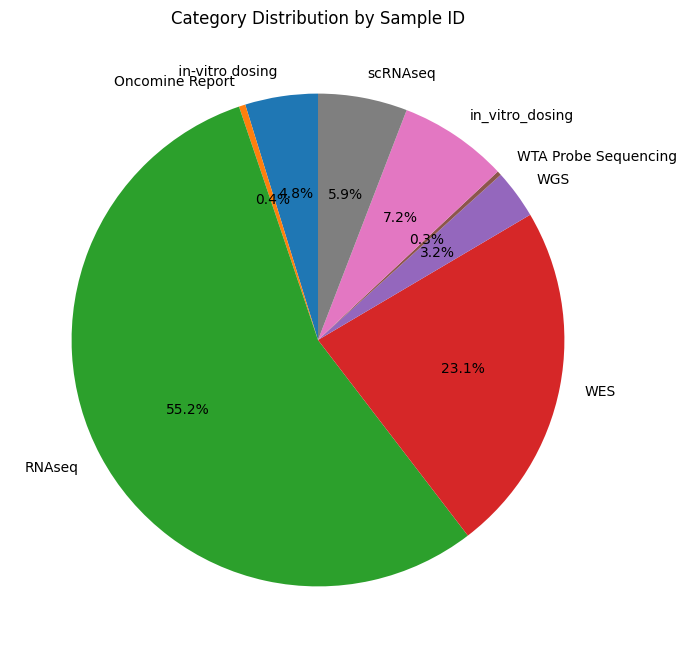

In [361]:
import altair as alt
import pandas as pd

# Assuming merged_df is your DataFrame
# Group by 'Data_type', 'File type', 'Patient ID', and 'Specimen ID' and count unique 'Sample ID's
piechart = merged_df.groupby(["Data_type", "File type", "Patient ID", "Specimen ID"])["Sample ID"].size().reset_index(name="Count")

# Group by 'Data_type' to get counts for pie chart
counts = piechart.groupby("Data_type")["Count"].sum().reset_index()

# Create a selection object for interactivity
selection = alt.selection_single(fields=['Data_type'], bind='legend', name="Select Data Type")

# Create the pie chart using Altair
pie = alt.Chart(counts).mark_arc().encode(
    theta='Count:Q',
    color='Data_type:N',
    tooltip=['Data_type:N', 'Count:Q'],
).add_selection(
    selection
).properties(
    title="Category Distribution by Data Type"
)

# Show the pie chart in Streamlit
altair_chart(pie, use_container_width=True)

# Filter the data based on the selected Data_type
filtered_data = piechart[piechart["Data_type"].isin(counts[selection.selected]["Data_type"])]

# Get the file types for the selected Data_type
file_type_counts = filtered_data.groupby("File type")["Count"].sum().reset_index()

# Create a bar chart for File types using Altair
bar = alt.Chart(file_type_counts).mark_bar().encode(
    x='File type:N',
    y='Count:Q',
    color='File type:N',
    tooltip=['File type:N', 'Count:Q']
).properties(
    title="File Types for Selected Data Type"
)

# Show the bar chart in Streamlit
altair_chart(bar, use_container_width=True)
